# STDP - single synapse

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/STDP1.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/STDP1.ipynb)

In [1]:
#!pip install ANNarchy

This notebook demonstrates the online implementation of the spike time-dependent plasticity (STDP) rule for a pair of neurons.

In [2]:
import numpy as np
import ANNarchy as ann
import matplotlib.pyplot as plt

ANNarchy 4.8 (4.8.3) on darwin (posix).


The STDP learning rule maintains exponentially-decaying traces for the pre-synaptic and post-synaptic spikes.

$$\tau^+ \, \frac{d x(t)}{dt} = -x (t)$$

$$\tau^- \, \frac{d y(t)}{dt} = -x (t)$$

LTP and LTD occur at spike times depending on the corresponding traces.

* When a pre-synaptic spike occurs, $x(t)$ is incremented and **LTD** is applied proportionally to $y(t)$.
* When a post-synaptic spike occurs, $y(t)$ is incremented and **LTP** is applied proportionally to $x(t)$.

In [3]:
STDP = ann.Synapse(
    parameters = dict(
        tau_plus = 20.0,
        tau_minus = 20.0, 
        A_plus = 0.01,
        A_minus = 0.01,
        w_min = 0.0,
        w_max = 2.0,
    ),
    equations = [
        # Pre-synaptic trace
        ann.Variable('tau_plus * dx/dt = -x', method='event-driven'),
        # Post-synaptic trace
        ann.Variable('tau_minus * dy/dt = -y', method='event-driven'),
    ],
    pre_spike="""
        g_target += w
        x += A_plus * w_max
        w = clip(w - y, w_min , w_max) # LTD
    """,
    post_spike="""
        y += A_minus * w_max
        w = clip(w + x, w_min , w_max) # LTP
    """
)

We create two dummy populations with one neuron each, whose spike times we can control.

In [4]:
net = ann.Network()
pre = net.create(ann.SpikeSourceArray([[0.]]))
post = net.create(ann.SpikeSourceArray([[50.]]))

We connect the population using a STDP synapse.

In [5]:
proj = net.connect(pre, post, 'exc', STDP)
proj.connect_all_to_all(1.0)

In [6]:
net.compile()

Compiling network 1...  OK 


The presynaptic neuron will fire at various times between 0 and 100 ms, while the postsynaptic neuron keeps firing at 50 ms.

In [7]:
pre_times = np.linspace(100.0, 0.0, 101)

In [8]:
weight_changes = []

for t_pre in pre_times:
    
    # Reset the populations
    pre.clear()
    post.clear()
    pre.spike_times = [[t_pre]]
    post.spike_times = [[50.0]]
    
    # Reset the traces
    proj.x = 0.0
    proj.y = 0.0
    
    # Weight before the simulation
    w_before = proj[0].w[0]
    
    # Simulate long enough
    net.simulate(105.0)
    
    # Record weight change
    delta_w = proj[0].w[0] - w_before
    weight_changes.append(delta_w)

We can now plot the classical STDP figure:

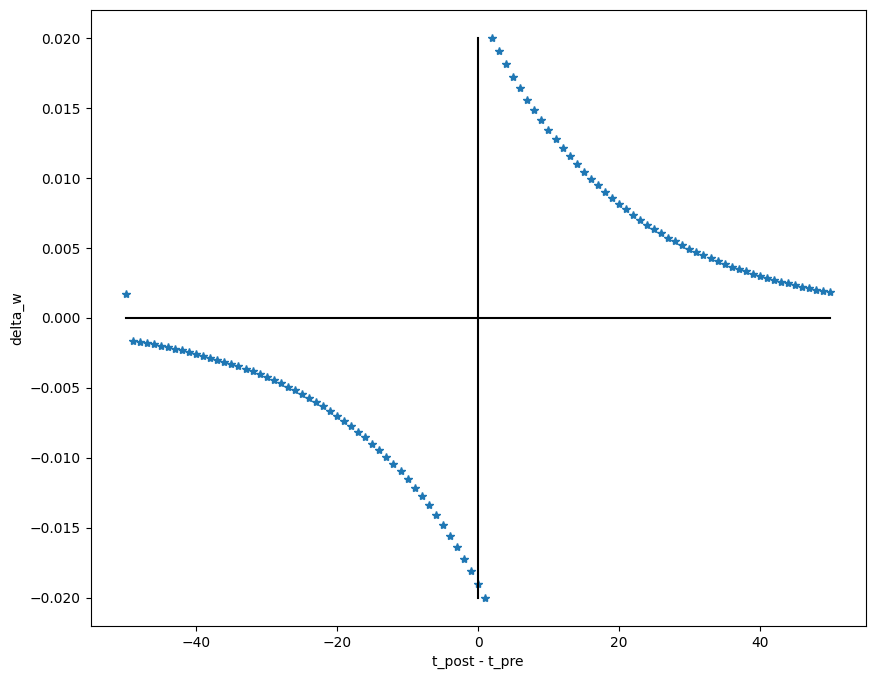

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(50. - pre_times, weight_changes, "*")
plt.plot([-50, 50], [0, 0], 'k')
plt.plot([0, 0], [min(weight_changes), max(weight_changes)], 'k')
plt.xlabel("t_post - t_pre")
plt.ylabel("delta_w")
plt.show()